**Speech Emotion Recognition**

---



**Mounting the GDrive for Dataset**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Importing Necessary Libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy.signal as signal
import soundfile
import glob
import joblib
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
import keras
from keras.layers import Dense, BatchNormalization, Conv1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential

**Data Visualization**

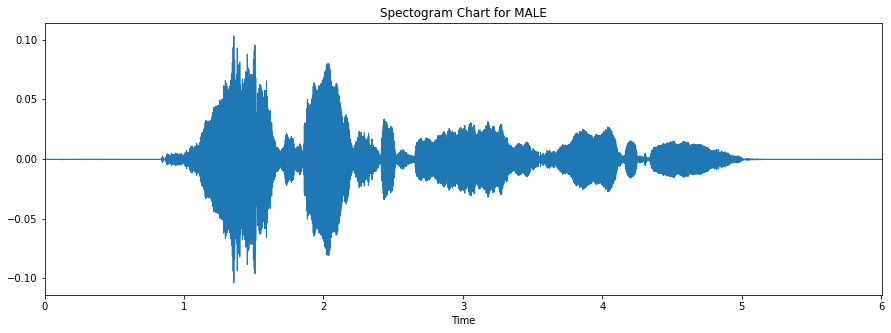

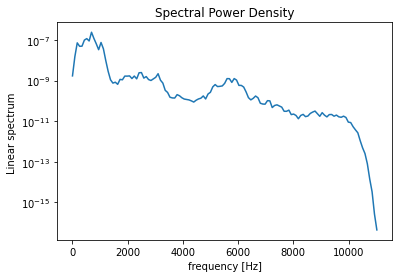

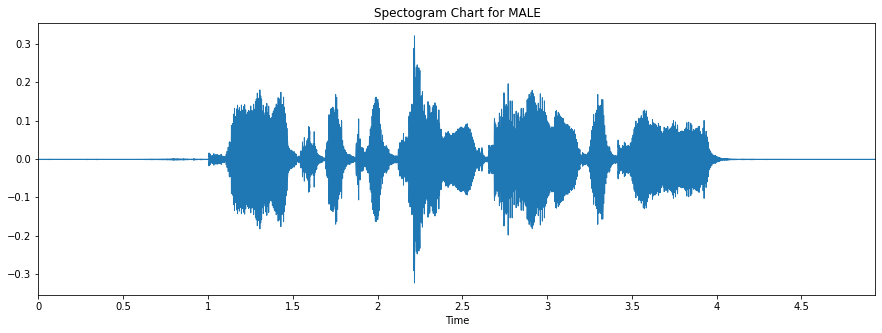

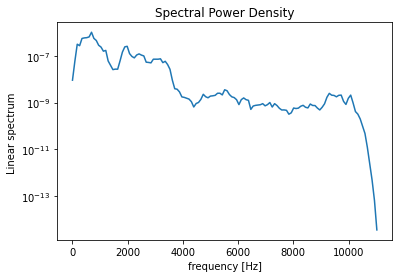

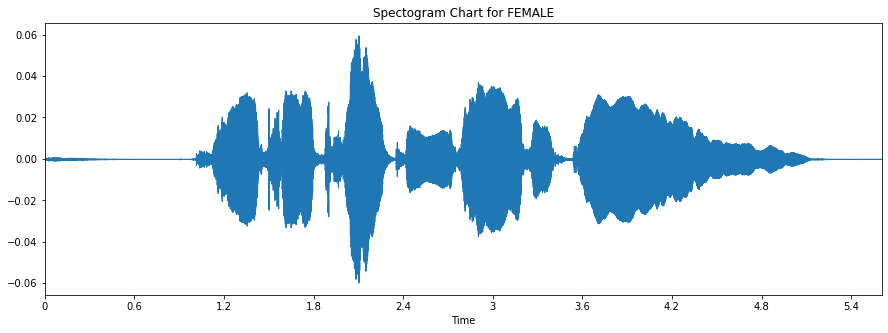

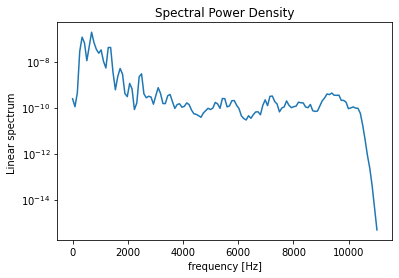

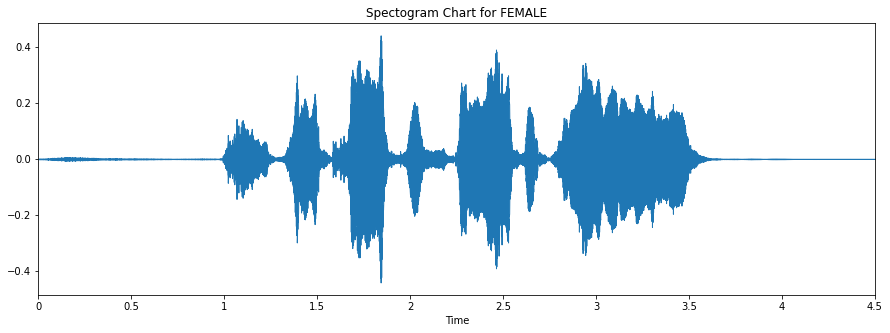

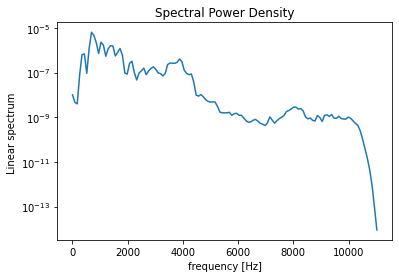

In [ ]:
path_male = "/content/gdrive/MyDrive/Speech Emotion Recognition Dataset/Dataset/Speech/Actor_05/"
male = ["03-02-02-02-02-02-05.wav", "03-02-05-02-01-02-05.wav"]

path_female = "/content/gdrive/MyDrive/Speech Emotion Recognition Dataset/Dataset/Speech/Actor_06/"
female = ["03-02-02-02-01-01-06.wav", "03-02-05-02-01-02-06.wav"]


#Plotting Spectograms for Male
for i in male: 
  """
  This part plots Spectogram for Male Actors
  """
  data, sampling_rate = librosa.load(path_male+i)
  plt.figure(figsize=(15, 5))
  plt.title("Spectogram Chart for MALE")
  librosa.display.waveplot(data, sr=sampling_rate)
  plt.show()


  """
  This part plots Spectral Power Density for Male Actors
  """
  f, Pxx_den = signal.welch(data, sampling_rate)
  plt.title("Spectral Power Density")
  plt.semilogy(f, Pxx_den)
  plt.xlabel('frequency [Hz]')
  plt.ylabel('Linear spectrum ')
  plt.show()
  

#Plotting Spectograms for Female
for i in female: 
  """
  This part plots Spectogram for Female Actors
  """
  data, sampling_rate = librosa.load(path_female+i)
  plt.figure(figsize=(15, 5))
  plt.title("Spectogram Chart for FEMALE")
  librosa.display.waveplot(data, sr=sampling_rate)
  plt.show()

  """
  This part plots Spectral Power Density for Female Actors
  """
  f, Pxx_den = signal.welch(data, sampling_rate)
  plt.title("Spectral Power Density")
  plt.semilogy(f, Pxx_den)
  plt.xlabel('frequency [Hz]')
  plt.ylabel('Linear spectrum ')
  plt.show()


In [ ]:
#Defining the Emotions

emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}


**Extarcting the Features from Input Audio**

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
    if mel:
                mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
                result=np.hstack((result, mel))
    return result

In [ ]:
def load_data():
    x,y=[],[]
    for file in glob.glob("/content/gdrive/MyDrive/Speech Emotion Recognition Dataset/Dataset/Speech/Actor_*/*.wav"):
      try:
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
      
      # If the file is not valid, skip it
      except:
        continue

    return np.array(x),y

In [ ]:
X,y = load_data()
joblib.dump(X, os.path.join("/content/gdrive/MyDrive/Speech Emotion Recognition Dataset/JobLib/","X.joblib"))
joblib.dump(y, os.path.join("/content/gdrive/MyDrive/Speech Emotion Recognition Dataset/JobLib/","y.joblib"))

['/content/gdrive/MyDrive/Speech Emotion Recognition Dataset/JobLib/y.joblib']

**Loading the Data from Jobib**

In [ ]:
X = joblib.load("/content/gdrive/MyDrive/Speech Emotion Recognition Dataset/JobLib/X.joblib")
y = joblib.load("/content/gdrive/MyDrive/Speech Emotion Recognition Dataset/JobLib/y.joblib")


In [ ]:
def neural_network(X,y):

  y = np.array(y)
  for i in range(len(y)):
    if y[i] == 'neutral':
        y[i] = 0
    elif y[i] == 'calm':
        y[i] = 1
    elif y[i] == 'happy':
        y[i] = 2
    elif y[i] == 'sad':
        y[i] = 3
    elif y[i] == 'angry':
        y[i] = 4
    elif y[i] == 'fearful':
        y[i] = 5
    elif y[i] == 'disguist':
        y[i] = 6
    elif y[i] == 'surprise':
        y[i] = 7
  
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = y.reshape(len(y), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  print(onehot_encoded)
  x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state=42)
  x_val_train,x_val_test,y_val_train,y_val_test = train_test_split(x_train,y_train,test_size = 0.20)

  x_val_train = x_val_train.reshape(x_val_train.shape[0], -1)

  x_val_test = x_val_test.reshape(x_val_test.shape[0], -1)

  x_test = x_test.reshape(x_test.shape[0], -1)

  model = Sequential()
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(8))
  model.add(Activation('softmax'))

  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(lr=0.0001), metrics = ['accuracy'])
  print("x",x_val_train.shape)
  print("y",y_val_train.shape)
  cnn_history = model.fit(x_val_train, y_val_train, batch_size = 32, epochs = 30, validation_data=(x_val_test, y_val_test))

  # Loss plotting
  plt.plot(cnn_history.history['loss'])
  plt.plot(cnn_history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='best')
  plt.savefig('Model Loss.png')
  plt.show()
 

  # Accuracy plotting
  plt.plot(cnn_history.history['accuracy'])
  plt.plot(cnn_history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='best')
  plt.savefig('Model Accuracy.png')
  plt.show()


  score = model.evaluate(x_test, y_test, verbose=1)
    
  print('Test Loss: ', score[0])
  print('Test Accuracy: ', score[1])

neural_network(X,y)


**MLP CLassifier**

In [ ]:
def MLP(X,y):

  x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.30)

  model=MLPClassifier(batch_size=250, hidden_layer_sizes=(200,), activation='tanh',solver="adam",learning_rate='adaptive', max_iter=800,alpha=0.01)
  model.fit(x_train,y_train)

  y_pred=model.predict(x_test)
  accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
  print("Classification Report Using MLP CLassifier:\n",classification_report(y_test,y_pred))
  print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
  print("Testing Accuracy for MLP Classifier: {:.2f}%".format(accuracy*100))


MLP(X,y)

Classification Report Using MLP CLassifier:
               precision    recall  f1-score   support

       angry       0.88      0.86      0.87        51
        calm       0.80      0.87      0.84        47
     disgust       0.92      0.70      0.79        33
     fearful       0.70      0.86      0.78        36
       happy       0.92      0.81      0.86        57
     neutral       0.66      0.68      0.67        28
         sad       0.78      0.86      0.82        37
   surprised       0.59      0.57      0.58        23

    accuracy                           0.80       312
   macro avg       0.78      0.78      0.78       312
weighted avg       0.81      0.80      0.80       312

COnfusion Matrix:
 [[44  0  0  1  1  3  0  2]
 [ 0 41  0  1  1  0  4  0]
 [ 4  1 23  2  0  0  0  3]
 [ 0  1  1 31  0  0  3  0]
 [ 1  2  0  3 46  2  2  1]
 [ 0  2  0  3  1 19  0  3]
 [ 0  2  0  2  0  1 32  0]
 [ 1  2  1  1  1  4  0 13]]
Testing Accuracy for MLP Classifier: 79.81%


**Random Forest Classifier**

In [ ]:
def Rforest(X,y):

  x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.30)

  rforest=RandomForestClassifier(n_estimators=500,criterion="gini")
  rforest.fit(x_train,y_train)

  y_pred=rforest.predict(x_test)
  accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
  print("Classification Report Using Random Forest CLassifier:\n",classification_report(y_test,y_pred))
  print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
  print("Testing Accuracy for Random Forest Classifier: {:.2f}%".format(accuracy*100))


Rforest(X,y)

Classification Report Using Random Forest CLassifier:
               precision    recall  f1-score   support

       angry       0.75      0.82      0.78        49
        calm       0.78      0.89      0.83        55
     disgust       0.58      0.52      0.55        27
     fearful       0.46      0.61      0.52        38
       happy       0.80      0.74      0.77        54
     neutral       0.65      0.65      0.65        17
         sad       0.75      0.62      0.68        48
   surprised       0.60      0.38      0.46        24

    accuracy                           0.69       312
   macro avg       0.67      0.65      0.66       312
weighted avg       0.70      0.69      0.69       312

Confusion Matrix:
 [[40  0  1  3  1  0  0  4]
 [ 0 49  0  2  0  3  1  0]
 [ 3  2 14  3  0  1  3  1]
 [ 4  1  2 23  5  0  3  0]
 [ 5  3  3  3 40  0  0  0]
 [ 0  0  2  1  0 11  2  1]
 [ 0  8  1  8  1  0 30  0]
 [ 1  0  1  7  3  2  1  9]]
Testing Accuracy for Random Forest Classifier: 69.23%
